In [2]:

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from tqdm import tqdm

import matplotlib

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

# Exercise 2

Smoke from chimney

Create array of x an z dimensions + set initial plume

In [3]:
time=1001
Nx=500 #Length of x
Nz=100 #height of z


xmax=Nx #number of points in x
xmin=0

zmax=Nz #number of points in z
zmin=0


arr= np.zeros((Nz, Nx, time))

plume=xr.DataArray(arr.copy(),dims=('z','x','time')) #km, m
#plume[19:21,0:3,:]=1 #Set initial plume

plume['x']=np.linspace(xmin,xmax,Nx)
plume['z']=np.linspace(zmin,zmax,Nz)

arr= np.zeros((Nz, Nx))

S1=xr.DataArray(arr.copy(),dims=('z','x')) #km, m

S1[40:45,30:45]=1 #Set initial plume for all n,# no need to add Source in for-loop
#plume['z']=xr.DataArray=(np.linspace(zmin,zmax,Nz), dims='z')

In [4]:
D0=0.07
kappa=0.41
z0=0.01
U0=0.1 

z=plume.z.values+0.0001 #To not divide by 0

U= (U0/kappa)*(np.log(z/z0)) #np.zeros(len(z))+1
U[0]=0
#W=np.zeros(len(plume.x))
#W[10:20]=3 #Set vertical velocity at some points
D=np.zeros(len(z))+D0 #kappa*U0*z #D0 molecular diffusivity kappa*U*z 

#Add a velocity upwards, constant throughout the whole field?

dx=10#(xmax-xmin)/Nx
dz=1#(zmax-zmin)/Nz



dt=2

In [46]:
S=S1.copy().values
plume1=plume[:,:,:].copy().values

for n in tqdm(np.arange(0,len(plume.time)-1)): #time

    for i in np.arange(1,len(plume.x)-1): #x
        for j in np.arange(1, len(plume.z)-1): #z
            
            new=(S[j,i]
                +D[j]*((plume1[j,i-1,n]-2*plume1[j,i,n]+plume1[j,i+1,n])/dx**2) #diffusion x-direction
            +D[j]*((plume1[j-1,i,n]-2*plume1[j,i,n]+plume1[j+1,i,n])/dz**2) #diffusion z-direction
            -U[j]*(-plume1[j,i-1,n]+plume1[j,i,n])/dx) #advection in x with upstream wind
          #  -W[i]*(-plume1[j-1,i,n]+plume1[j,i,n])/dz) #Advection in z, just to test, not successful
             #Source added here #source already added in plume array to avoid a extra step in for-loop
           
            plume1[j,i,n+1]=plume1[j,i,n]+new*dt #add new values times dt to next timestep 
            #print(plume[j,i,n].values)   

100%|███████████████████████████████████████| 1000/1000 [03:08<00:00,  5.29it/s]


In [47]:
plume= xr.DataArray(plume1, 
coords={'z': plume.z,'x': plume.x,'time': plume.time}, 
dims=["z", "x", "time"])

In [48]:
plume.to_netcdf('plume_999_D_007_REPORT.nc')

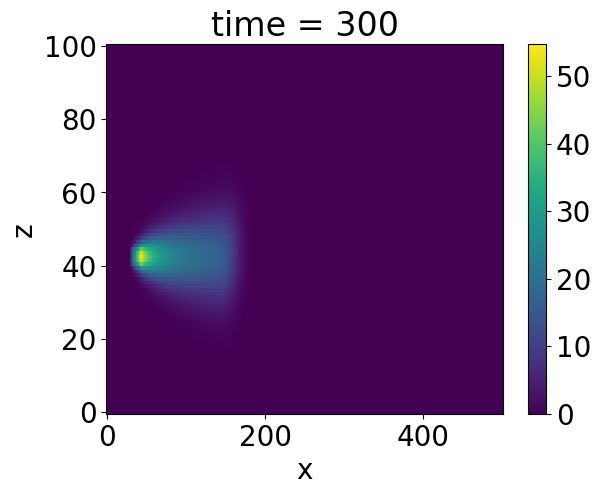

In [49]:
plume.sel(time=300).plot()

In [50]:
#Saved files

plume_base=xr.open_dataset('plume_999_var_U_REPORT.nc') #As table 1
plume_const_U=xr.open_dataset('plume_999_const_U_REPORT.nc') #Constant U=1 m/s
plume_D007=xr.open_dataset('plume_999_D_007_REPORT.nc') #D=0.07

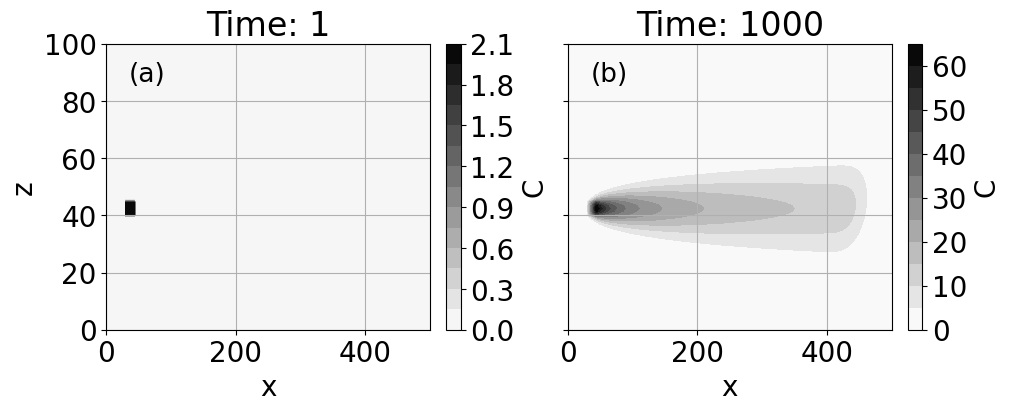

In [84]:
time1=1
time2=1000
fig, ax= plt.subplots(1,2, figsize=[10,4], sharey=True, sharex=True, constrained_layout=True)

cb=ax[0].contourf(plume_base.x, plume_base.z, plume_base.sel(time=time1).__xarray_dataarray_variable__, cmap='binary', levels=14)
plt.colorbar(cb, ax=ax[0], label='C')


cb=ax[1].contourf(plume_base.x, plume.z, plume_base.sel(time=time2).__xarray_dataarray_variable__, vmin=1, cmap='binary', levels=14)
plt.colorbar(cb, ax=ax[1], label='C')



ax[0].set_xlabel('x')
ax[0].set_ylabel('z')
ax[1].set_xlabel('x')

ax[0].set_title('Time: '+str( plume_base.sel(time=time1).time.values))
ax[1].set_title('Time: '+str( plume_base.sel(time=time2).time.values))

ax[0].grid()
ax[1].grid()

ax[0].annotate( '(a)', xy=(0.07, 0.87), xycoords='axes fraction',fontsize=19)
ax[1].annotate( '(b)', xy=(0.07, 0.87), xycoords='axes fraction',fontsize=19)  

plt.savefig('plume_999_1.png')

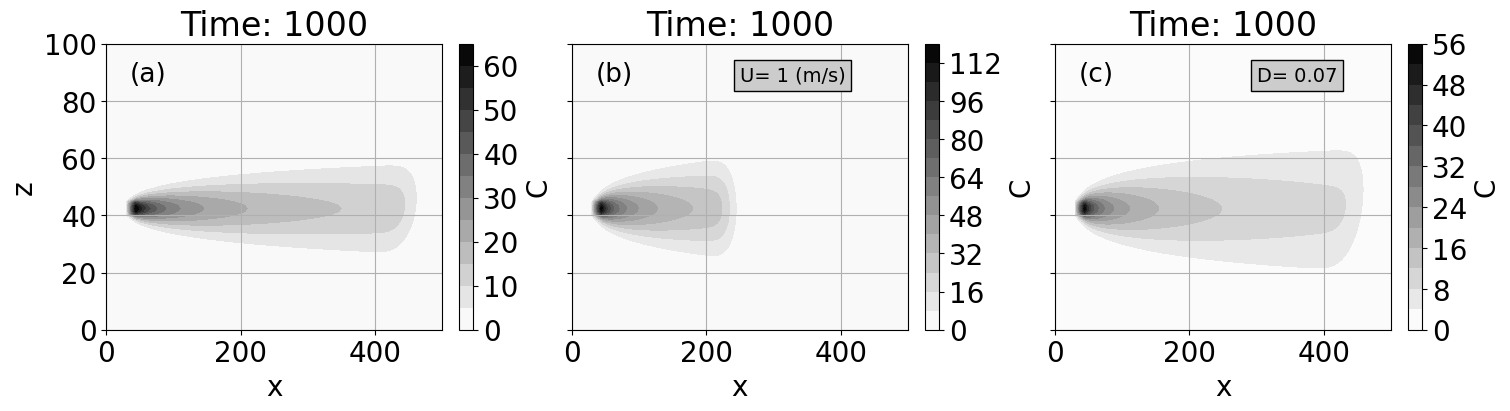

In [77]:
time1=1000
time2=1000
figs=3

fig, ax= plt.subplots(1,figs, figsize=[15,4], sharey=True, sharex=True, constrained_layout=True)

cb=ax[0].contourf(plume_base.x, plume_base.z, plume_base.sel(time=time1).__xarray_dataarray_variable__, vmin=1, cmap='binary', levels=14)
plt.colorbar(cb, ax=ax[0], label='C')


cb=ax[1].contourf(plume_const_U.x, plume_const_U.z, plume_const_U.sel(time=time2).__xarray_dataarray_variable__, vmin=1, cmap='binary', levels=14)
plt.colorbar(cb, ax=ax[1], label='C')

cb=ax[2].contourf(plume_D007.x, plume_D007.z, plume_D007.sel(time=time2).__xarray_dataarray_variable__, vmin=1, cmap='binary', levels=14)
plt.colorbar(cb, ax=ax[2], label='C')


for i in np.arange(figs):
    ax[i].set_xlabel('x')
    ax[i].grid()
    ax[i].set_title('Time: '+str( plume_base.sel(time=time1).time.values))

ax[0].set_ylabel('z')

ax[0].annotate( '(a)', xy=(0.07, 0.87), xycoords='axes fraction',fontsize=19)
ax[1].annotate( '(b)', xy=(0.07, 0.87), xycoords='axes fraction',fontsize=19)  
ax[2].annotate( '(c)', xy=(0.07, 0.87), xycoords='axes fraction',fontsize=19)

bbox = dict(boxstyle="square", fc="0.8")

text_x=0.5
text_y=0.87

#ax[0].annotate('Table 1', xy=(text_x-0.2, text_y), xycoords='axes fraction', bbox=bbox, fontsize=14)
ax[1].annotate('U= 1 (m/s)', xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox, fontsize=14)
ax[2].annotate('D= 0.07', xy=(text_x+0.1, text_y), xycoords='axes fraction', bbox=bbox, fontsize=14)


plt.savefig('plume_varU_vs_constU1_D007.png')

Save figs in folder figs

In [96]:
for time in tqdm(np.arange(1,len(plume.time)-1)):
    plt.contourf(plume.x, plume.z, plume.sel(time=time), cmap='binary', levels=14)
    plt.colorbar(label='Concentration')
    plt.xlabel('x')
    plt.ylabel('z')

    plt.title('Time: '+str( plume.sel(time=time).time.values))
    plt.savefig(pathlib.Path('.').absolute().parent/ f'001-Ex/figs/pic_{time:04}.png')
    plt.close()

100%|█████████████████████████████████████████| 998/998 [01:26<00:00, 11.51it/s]


Create animation from figs saved in previous cell

In [97]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ '001-Ex/figs'
fps=15

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('plume.mp4')

Moviepy - Building video plume.mp4.
Moviepy - Writing video plume.mp4



Moviepy - Done !
Moviepy - video ready plume.mp4
